# Programming assignment 2: Random forests

Leo Carlsson and Efstathios Sidiropoulos.

## Task 1: Working with a dataset with categorical features

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import  accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

### Step 1. Reading the data

In [2]:
train = pd.read_csv('https://www.cse.chalmers.se/~richajo/dit866/data/adult_train.csv')
test = pd.read_csv('https://www.cse.chalmers.se/~richajo/dit866/data/adult_test.csv')

In [3]:
train.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,27,Private,Some-college,10,Divorced,Adm-clerical,Unmarried,White,Female,0,0,44,United-States,<=50K
1,27,Private,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,40,United-States,<=50K
2,25,Private,Assoc-acdm,12,Married-civ-spouse,Sales,Husband,White,Male,0,0,40,United-States,<=50K
3,46,Private,5th-6th,3,Married-civ-spouse,Transport-moving,Husband,Amer-Indian-Eskimo,Male,0,1902,40,United-States,<=50K
4,45,Private,11th,7,Divorced,Transport-moving,Not-in-family,White,Male,0,2824,76,United-States,>50K


In [4]:
x_train = train.drop('target', axis=1)
y_train = train['target']

In [5]:
x_test = test.drop('target', axis=1)
y_test = test['target']

### Step 2: Encoding the features as numbers.

In [6]:
# Convert the DataFrame to a list of dictionaries
dicts_for_my_training_data = x_train.to_dict('records')
dicts_for_my_test_data = x_test.to_dict('records')

In [7]:
from sklearn.feature_extraction import DictVectorizer

# Create an instance of DictVectorizer
dv = DictVectorizer()

# Fit and transform the training data
x_train_encoded = dv.fit_transform(dicts_for_my_training_data)

# Transform the test data, using the same mapping
x_test_encoded = dv.transform(dicts_for_my_test_data)

### Step 3. Combining the steps.

In [8]:
from sklearn.pipeline import make_pipeline
  

# Create the Pipeline
pipeline = make_pipeline(
  DictVectorizer(),
  DecisionTreeClassifier()
)

In [9]:
# Initialize the pipeline
dtc_pipeline = pipeline.fit(dicts_for_my_training_data, y_train)

In [10]:
#Test predict
dtc_pipeline.predict(dicts_for_my_test_data)

array(['<=50K', '<=50K', '<=50K', ..., '>50K', '<=50K', '<=50K'],
      dtype=object)

## Task 2: Decision trees and random forests

### Underfitting and overfitting in decision tree classifiers.

In [11]:
# Initialize Decision Tree clf
dtc = DecisionTreeClassifier()

# Train the clf
dtc_model = dtc.fit(x_train_encoded, y_train)

In [12]:
#Make predictions for the DTC
y_preds = dtc_model.predict(x_test_encoded)

In [13]:
# DTC Accuracy
dtc_accuracy = accuracy_score(y_pred=y_preds, y_true=y_test)
dtc_accuracy

0.8175787728026535

### Underfitting and overfitting in random forest classifiers.

In [14]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest clf
rfc = RandomForestClassifier()

# Train the clf
rfc_model = rfc.fit(x_train_encoded, y_train)

In [15]:
# Make predictions for the RFC
y_preds = rfc_model.predict(x_test_encoded)

In [16]:
# RFC Accuracy
rfc_accuracy = accuracy_score(y_pred=y_preds, y_true=y_test)
rfc_accuracy

0.8462010932989374

We can see that a basic Random Forest classifier performs better than the basic Decision Tree classifier.

Now let's try tuning the Random Forest classifier.

In [17]:
# Define the range of ensemble sizes to test
ensemble_sizes = range(1, 201, 10)

# Define the range of maximal tree depths to test
max_depths = range(1, 21)

# Initialize a dictionary to store the accuracy scores for each ensemble size and maximal tree depth
accuracy_scores = {size: [] for size in ensemble_sizes}

In [18]:
# # Plot the accuracy scores for each ensemble size and maximal tree depth
# plt.figure(figsize=(16,18))
# for size in ensemble_sizes:
#     plt.plot(max_depths, accuracy_scores[size], label='Ensemble size: {}'.format(size))
# plt.xlabel('Maximal tree depth', fontsize=18)
# plt.ylabel('Accuracy', fontsize=18)
# plt.legend()
# plt.show()

In [19]:
def eval_classifier(x, y, n_tree, max_depth):
    tree_range = range(1, n_tree, 10)

    accuracy_scores = {n_tree: [] for n_tree in tree_range}

    for n_tree in tree_range:
        for depth in range(1, max_depth+1):
            classifier = RandomForestClassifier(n_estimators=n_tree, max_depth = depth, n_jobs = -1)
            classifier.fit(x, y)
            score = accuracy_score(y, classifier.predict(x))
            accuracy_scores[n_tree].append(score)


    return accuracy_scores

In [20]:
train_eval = eval_classifier(x_train_encoded, y_train, 201, 21)
test_eval = eval_classifier(x_test_encoded, y_test, 201, 21)

In [21]:
len(train_eval.keys())

20

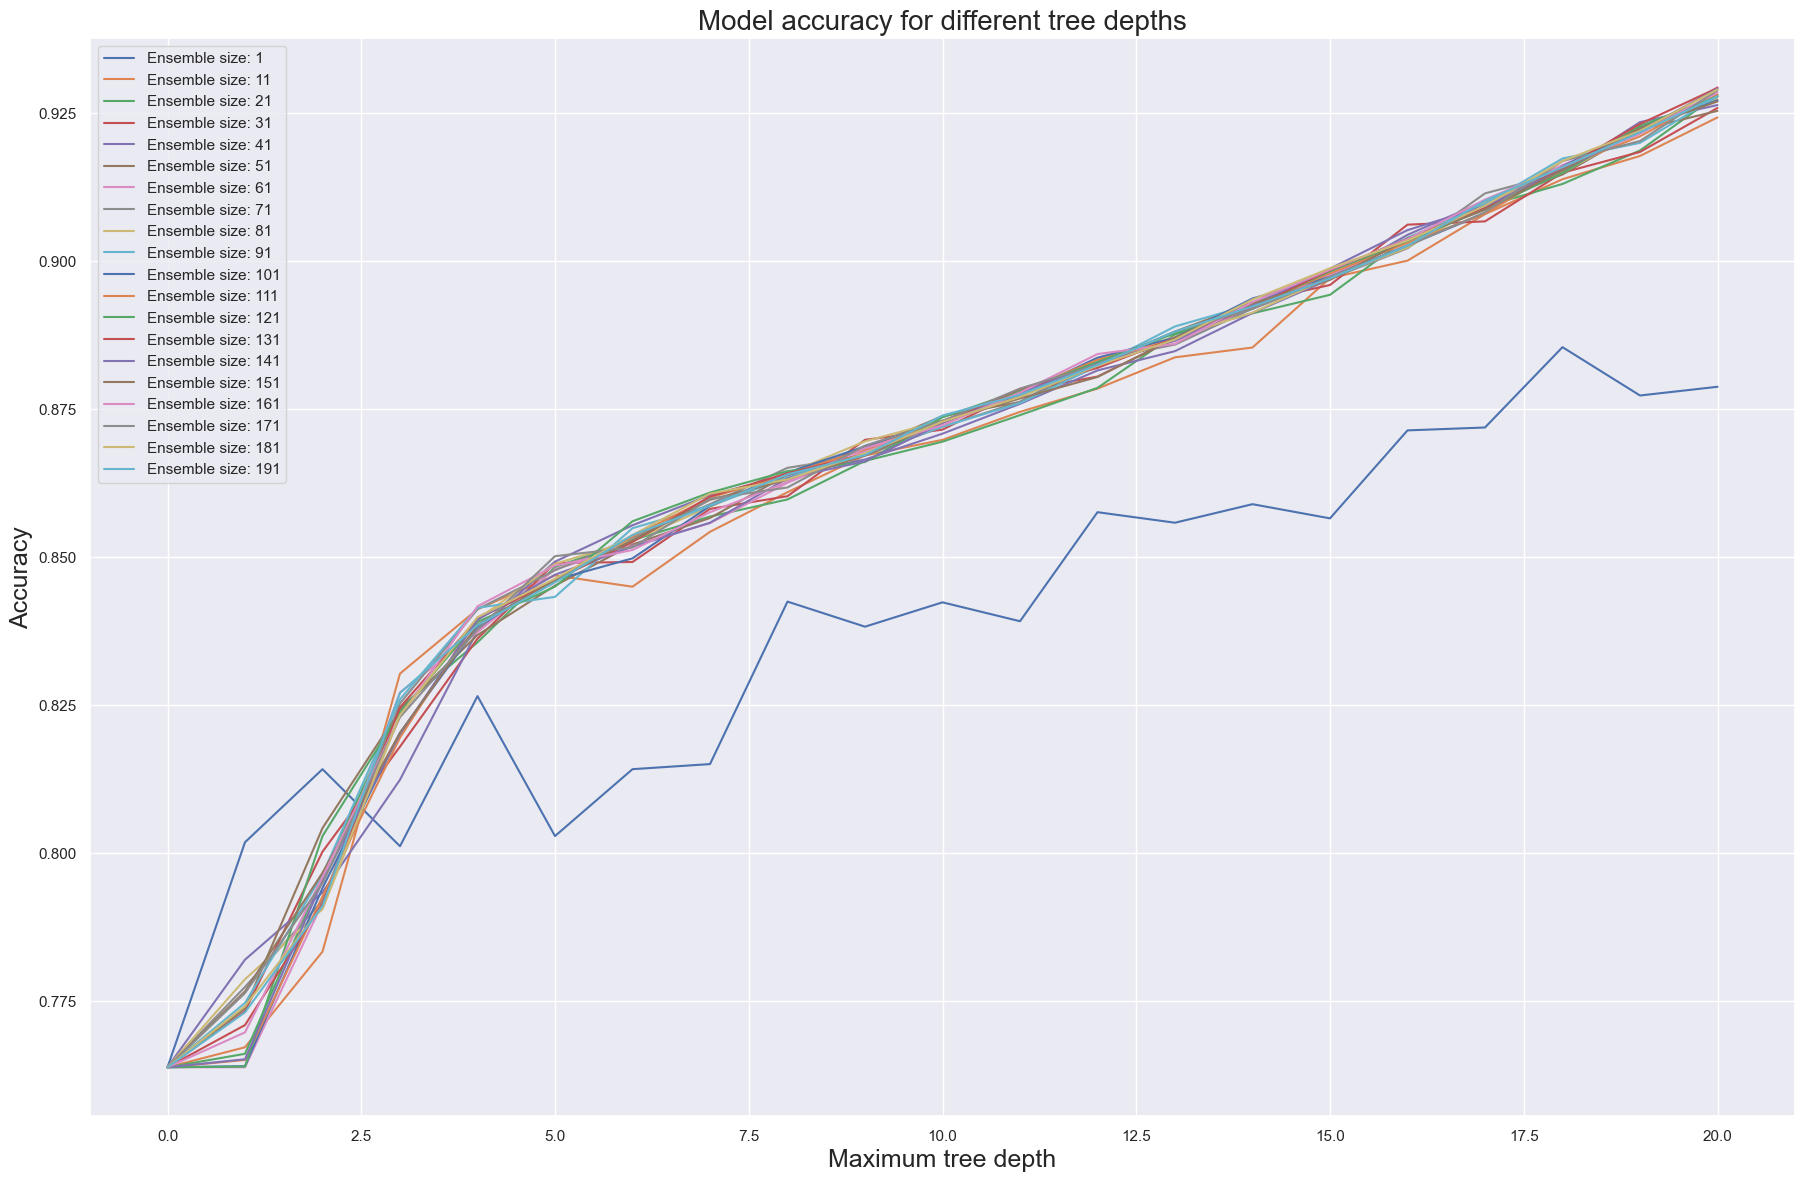

In [22]:
# Plot the accuracy scores for each ensemble size and maximal tree depth
plt.figure(figsize=(22,14))
for size in ensemble_sizes:
    plt.plot(test_eval[size], label='Ensemble size: {}'.format(size))
plt.xlabel('Maximum tree depth', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.title("Model accuracy for different tree depths", size=20)
plt.legend()
plt.show()

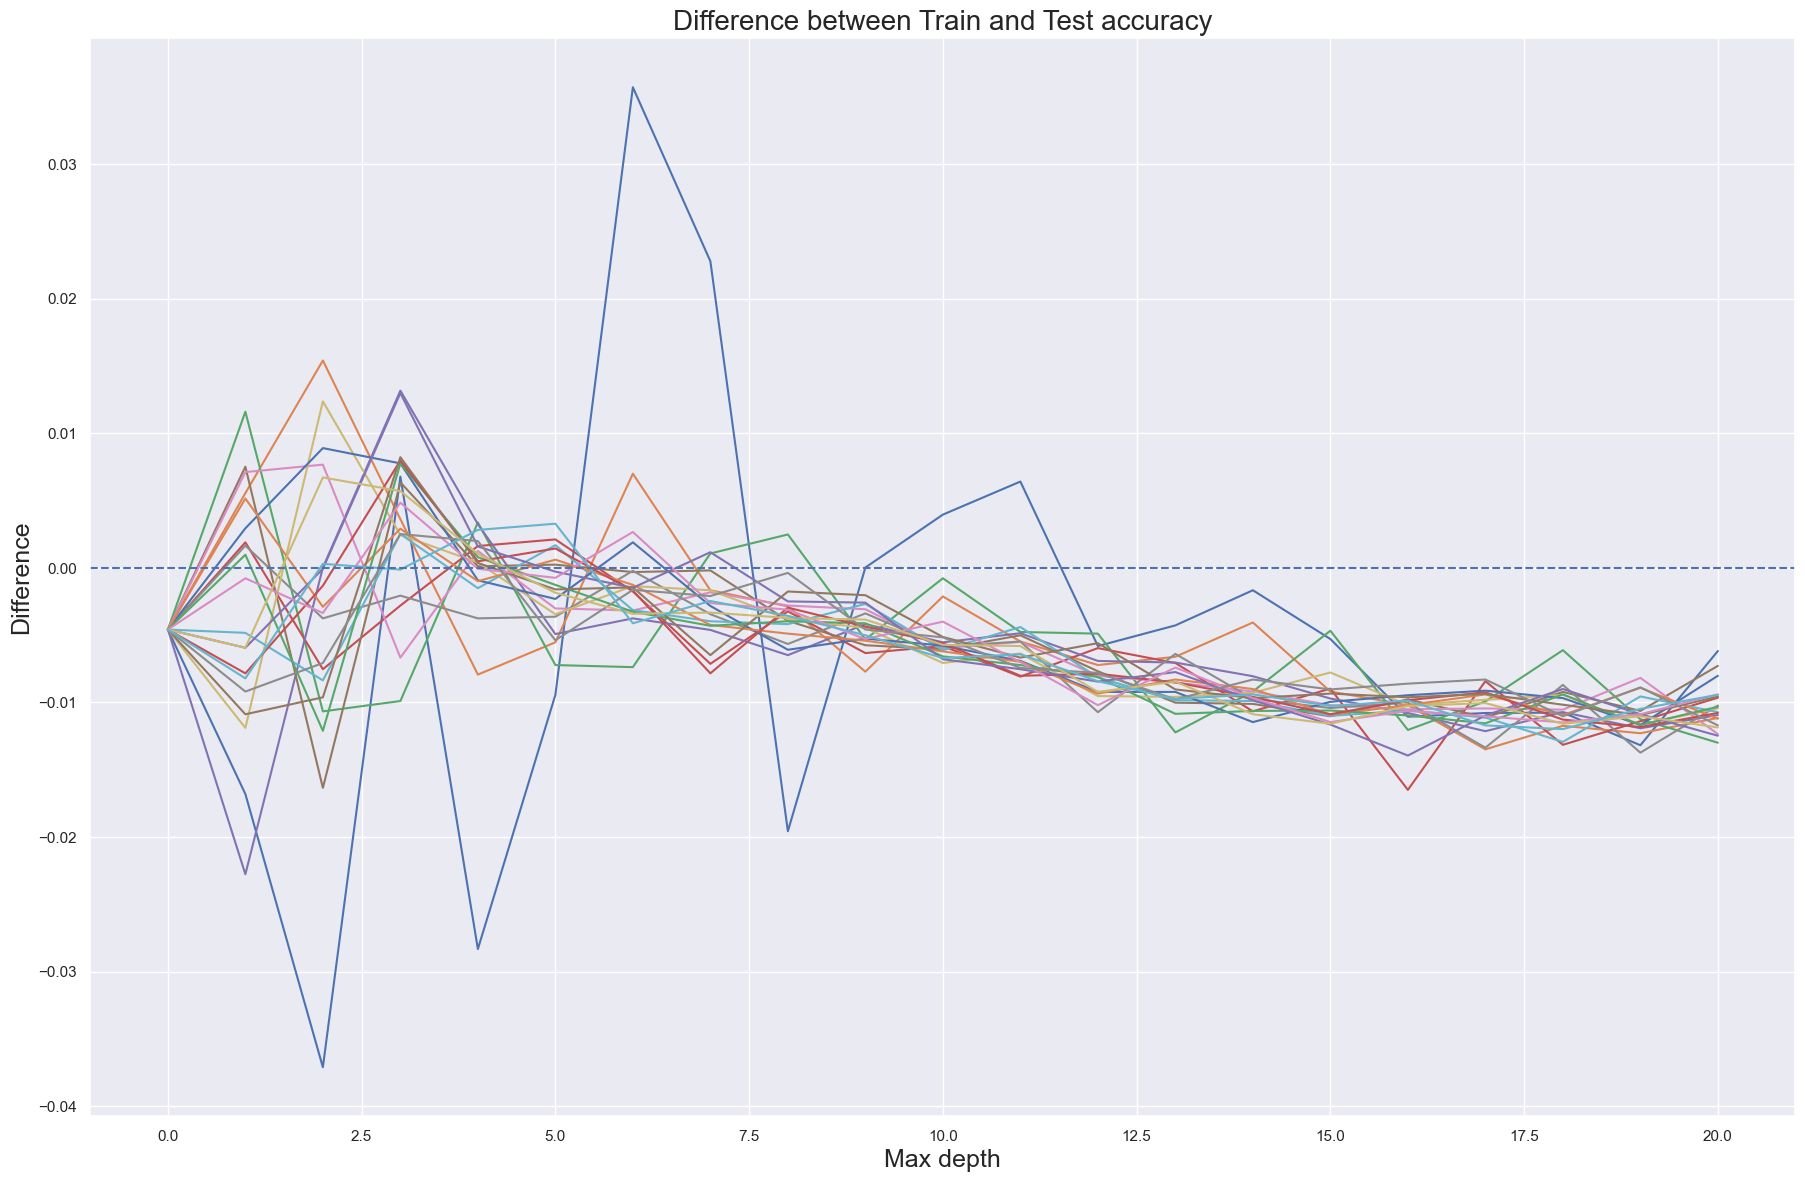

In [23]:
plt.figure(figsize=(22,14))
for key in train_eval.keys():
    diff = np.array(train_eval[key]) - np.array(test_eval[key])
    plt.plot(diff)

plt.axhline(y = 0, linestyle = 'dashed')
plt.xlabel("Max depth", fontsize=18)
plt.ylabel("Difference", fontsize=18)
plt.title("Difference between Train and Test accuracy", size=20)
plt.show()

It looks like as the max depth is increasing, the difference is becoming negative, meaning the test set accuracy is increasing compared to train set.

#### - What's the difference between the curve for a decision tree and for a random forest with an ensemble size of 1, and why do we see this difference? 

A Decision Tree is a single model that is created by iteratively dividing the data into subsets according to the values of the input features. A decision tree's accuracy can vary depending on the particular dataset it was trained on and the parameters that were used to build it. On the other hand, an ensemble of decision trees makes up a Random Forest. The random forest closely resembles a single decision tree when the ensemble size is set to 1. The accuracy will therefore be the same as a decision tree.

In [24]:
print('The length of our Decision Tree Classifier is:', dtc_model.tree_.max_depth)

The length of our Decision Tree Classifier is: 51


In [25]:
print('Decision Tree Classifier accuracy:', dtc_accuracy)
print('Random Forest Classifier with ensemble size 1 accuracy:', np.mean(test_eval[1]))

Decision Tree Classifier accuracy: 0.8175787728026535
Random Forest Classifier with ensemble size 1 accuracy: 0.8388071400785607


As seen above, there is a difference in accuracy for our models. That can be attributed to the difference hyperparameters used to train them. It is very likely that if we had set n_estimators=1 and max_depth=52 we would get the same accuracy. However, we did not test our models for such high depth, so let's try again.

In [26]:
#Initialize our test model
rfc_2 = RandomForestClassifier(n_estimators=1, max_depth=dtc_model.tree_.max_depth, n_jobs=-1)

#Fit our test model
rfc_2.fit(x_train_encoded, y_train)

#Preduct values
y_preds_rfc2 = rfc_2.predict(x_test_encoded)

#Accuracy
rfc2_acc = accuracy_score(y_pred=y_preds_rfc2, y_true=y_test)

In [27]:
dtc_accuracy-rfc2_acc

0.009274614581413987

There is still a minor difference, we can probably attribute to randomness.

#### - What happens with the curve for random forests as the ensemble size grows?

As we can see in the plot for the accuracy for different depths, pretty much every ensemble for n_estimators $> 1$ follows the same trend. 

#### - What happens with the best observed test set accuracy as the ensemble size grows?

The best observed test set accuracy of a random forest will often rise as the ensemble size rises. This is due to the fact that numerous decision trees' predictions are combined to get a final prediction, and as the ensemble's size grows, a decrease in overfitting may occur due to the randomness of each decision tree's training process. Additionally, as the ensemble of trees grows, the random forest can capture more of the underlying relationships and patterns in the data, improving accuracy. As soon as there are enough decision trees in the ensemble, this accuracy improvement will eventually plateau. More decision trees won't considerably increase accuracy after that point. Which turns our algorithm into an optimization problem, find the "sweet spot" of maximizing accuracy, decreasing overfitting while we do not use unnecessary computational power.

#### - What happens with the training time as the ensemble size grows?
The complexity of training a random forest depends on several factors including the size of the training dataset, the number of decision trees in the ensemble, and the complexity of the individual decision trees, as expected.

When the ensemble size is 1, the complexity is the same as a single decision tree. However, when the ensemble size is greater than 1, the total time and space complexity of training the random forest is the sum of the time and space complexity of building each individual decision tree.

Each decision tree in the ensemble typically takes $O(nmlog(n))$ amount of time to build, where $n$ is the number of instances in the training set and $m$ is the number of features. The complexity of space is typically $O(nm)$.

## Task 3: Feature importances in random forest classifiers

In [28]:
# Print the feature importance scores
pipeline = make_pipeline(
    DictVectorizer(),
    RandomForestClassifier(n_estimators = 200, n_jobs=-1)
)

m1 = pipeline.fit(dicts_for_my_training_data, y_train)

In [29]:
importance = m1.steps[1][1].feature_importances_
names = m1.steps[0][1].feature_names_

pd.DataFrame(data = {"names": names, "importance" : importance}).sort_values(by=["importance"], ascending = False)

,names,importance
0,age,2.281791e-01
20,hours-per-week,1.141285e-01
1,capital-gain,1.082908e-01
3,education-num,6.801648e-02
23,marital-status=Married-civ-spouse,6.641851e-02
...,...,...
56,native-country=Outlying-US(Guam-USVI-etc),3.230412e-05
72,occupation=Armed-Forces,1.630445e-05
44,native-country=Honduras,5.588361e-06
101,workclass=Never-worked,2.321254e-06


#### Alternatives for feature importance:
##### LASSO

By including a regularization component to the cost function, the LASSO linear regression approach prevents overfitting. The mean squared error term is increased by this regularization term, which is a parameter multiplied by the total absolute value of the coefficients. This term is used to effectively remove the model's less significant features by shrinking their coefficients all the way to zero.

The magnitude of the coefficients can be used to gauge the significance of a feature after the LASSO model has been trained. Due to their stronger influence on the model's prediction, features with larger coefficients are thought to be more significant than those with smaller coefficients.

A LASSO model can be trained with various regularization parameter values, and the magnitude of the coefficients for each feature can then be examined to determine the feature importance scores. Since they are most closely related to the outcome variable, the features with the biggest coefficients will be regarded as being the most crucial.

##### Principal Component Analysis (PCA) and Factor Analysis

There are a few other statistical techniques we could use to determine the most important features. Two techniques that could be used, but that return transformed features, Principal Component Analysis (PCA) and Factor Analysis.

PCA calculates new "components" that represent the data in different dimensions, where the first component is a straight line, the second component is 90 degrees orthogonal to that, the third component orthogonal in another dimension and so on. Each component then represents different ammounts of variance in the dataset, and if several of the original features are correlated, the the first components will represent more of the variance in the dataset. 

This way, either a set number of components can be selected (ie the top 5 or 10), or a set variance explained (ie we want components representing 95% of the variance in the original dataset). 

Factor Analysis works in a similar way, but with a statistical model rather than a mathematical representation, and works on the covariance rather than the variance. The results however are the same in that the number of features are reduced. 

This differs from Parr et al's (2018) solution of permutation importance, which is based on first calculating a baseline metric, then randomly permute a column, predict using the new dataset and calculate the metric, then permute the next column. The difference in metrics then gives a robust score of importance, since if a feature still has high accuracy when it was randomly permuted, it's not that important, but if it lowers the accuracy wildly, we know it's important.

There are a few other statistical techniques we could use to determine the most important features. Two techniques that could be used, but that return transformed features, Principal Component Analysis (PCA) and Factor Analysis.

PCA calculates new "components" that represent the data in different dimensions, where the first component is a straight line, the second component is 90 degrees orthogonal to that, the third component orthogonal in another dimension and so on. Each component then represents different ammounts of variance in the dataset, and if several of the original features are correlated, the the first components will represent more of the variance in the dataset. 

This way, either a set number of components can be selected (ie the top 5 or 10), or a set variance explained (ie we want components representing 95 % of the variance in the original dataset). 

Factor Analysis works in a similar way, but with a statistical model rather than a mathematical representation, and works on the covariance rather than the variance. The results however are the same in that the number of features are reduced. 

This differs from Parr et al's (2018) solution of permutation importance, which is based on first calculating a baseline metric, then randomly permute a column, predict using the new dataset and calculate the metric, then permute the next column. The difference in metrics then gives a robust score of importance, since if a feature still has high accuracy when it was randomly permuted, it's not that important, but if it lowers the accuracy wildly, we know it's important.